Bilal Choudhary - Submission


In [ ]:
# script from the piazza post
# https://piazza.com/class/lv2zctlo4nf1rm/post/726

!pip install kaggle
!echo '{"username":"bilalahmadchoudhary","key":"8320354a364e4a7a482f7f0b458ef5a0"}' > kaggle.json
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c cs-480-2024-spring
!unzip *.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train_images/196207162.jpeg  
  inflating: data/train_images/196207164.jpeg  
  inflating: data/train_images/196207198.jpeg  
  inflating: data/train_images/196207403.jpeg  
  inflating: data/train_images/196207539.jpeg  
  inflating: data/train_images/196207572.jpeg  
  inflating: data/train_images/196207729.jpeg  
  inflating: data/train_images/196207888.jpeg  
  inflating: data/train_images/196208355.jpeg  
  inflating: data/train_images/196208682.jpeg  
  inflating: data/train_images/196208848.jpeg  
  inflating: data/train_images/196209074.jpeg  
  inflating: data/train_images/196209078.jpeg  
  inflating: data/train_images/196209236.jpeg  
  inflating: data/train_images/196209887.jpeg  
  inflating: data/train_images/196209889.jpeg  
  inflating: data/train_images/196209960.jpeg  
  inflating: data/train_images/196210323.jpeg  
  inflating: data/train_images/196211220.jpeg  
  inflating: data/train_images/196211

First, set up the libraries and paths of the data that the model will be working used, including both the training and validation set

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Followed tutorial for data loaders and dataset

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import nn, optim
from PIL import Image

class PlantTraitDataset(Dataset):
    def __init__(self, dataframe, image_directory, transformations=None, is_training=True):
        """
        Args:
            dataframe (pd.DataFrame): The dataframe containing the data.
            image_directory (str): The directory where images are stored.
            transformations (callable, optional): Optional transformations to be applied on a sample.
            is_training (bool): Indicates if the dataset is for training. If False, adjusts column slicing.
        """
        self.dataframe = dataframe.copy()
        self.dataframe.iloc[:, 0] = self.dataframe.iloc[:, 0].astype(str)  # Convert image IDs to strings
        self.image_directory = image_directory
        self.transformations = transformations
        self.is_training = is_training

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_id = self.dataframe.iloc[index, 0] + '.jpeg'
        image_path = os.path.join(self.image_directory, image_id)

        # Check for missing images and handle accordingly
        if not os.path.isfile(image_path):
            print(f"Warning: The image file {image_path} is missing. Returning None...")
            return None, None, None

        # Open and transform the image
        image = Image.open(image_path).convert('RGB')
        if self.transformations:
            image = self.transformations(image)

        if self.is_training:
            # For training data, slice excluding the last 6 columns (target values)
            auxiliary_data = self.dataframe.iloc[index, 1:-6].values.astype(float)
        else:
            # For test data, assume all columns after the first are auxiliary data
            auxiliary_data = self.dataframe.iloc[index, 1:].values.astype(float)

        auxiliary_data = torch.tensor(auxiliary_data, dtype=torch.float32)

        # Extract target values
        if self.is_training:
            target_values = self.dataframe.iloc[index, -6:].values.astype(float)
            target_values = torch.tensor(target_values, dtype=torch.float32)
        else:
            target_values = torch.tensor([])

        return image, auxiliary_data, target_values


In [ ]:
# Load data from source
data_dir = './data'
train_csv_path = os.path.join(data_dir, 'train.csv')
test_csv_path = os.path.join(data_dir, 'test.csv')
train_images_dir = os.path.join(data_dir, 'train_images')
test_images_dir = os.path.join(data_dir, 'test_images')


train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# print shape
print("Shape of train_df:", train_df.shape)
print("Shape of test_df:", test_df.shape)

# extract the target cols and training cols
target_cols = train_df.columns[-6:]
aux_cols = train_df.columns[1:-6]


scaler = StandardScaler()
train_df[aux_cols] = scaler.fit_transform(train_df[aux_cols])
test_df[aux_cols] = scaler.transform(test_df[aux_cols])


# Split the training data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)




Shape of train_df: (43363, 170)
Shape of test_df: (6391, 164)


In [ ]:
# preview the data
train_df.head()
test_df.head()


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m03,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12
0,154220505,1.636059,1.703725,0.103678,-1.076465,-1.539277,-1.937576,-0.169845,-1.044876,-0.708645,...,-0.693989,-0.751390,-0.816091,-0.798587,-0.792618,-0.772051,-0.771197,-0.730069,-0.664125,-0.638491
1,195736552,1.103519,0.836333,1.323634,0.820245,-0.226566,-0.645130,1.129694,1.093266,1.221136,...,-0.995304,-0.796273,-0.663668,-0.734141,-0.951203,-0.985648,-0.740581,-0.755714,-0.794129,-0.814527
2,182701773,-1.672077,-0.355713,-0.543941,-0.677013,0.318551,0.059224,-0.508855,-0.176256,-0.459641,...,-0.112769,-0.229968,-0.120588,0.068969,0.171128,0.120779,-0.066345,0.126408,-0.128643,-0.133837
3,27688500,0.602749,-1.335113,-0.990611,-0.814826,-0.832582,-0.534540,0.790684,0.358280,0.349622,...,-1.967669,-1.973411,-1.914694,-1.834330,-1.851530,-1.850891,-1.856195,-1.917824,-2.013404,-2.018227
4,195825045,-0.949051,-0.686603,-0.793979,-1.141921,1.696642,1.328942,-0.395852,0.291463,0.038367,...,-0.795765,-0.448102,-0.127783,0.340601,0.424061,0.320228,-0.003482,-0.175382,-0.134244,-0.371522


In [ ]:
# image normalization and transformation
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_plant_data = PlantTraitDataset(train_data, train_images_dir, data_transform, True)
val_plant_data = PlantTraitDataset(val_data, train_images_dir, data_transform, True)
test_plant_data = PlantTraitDataset(test_df, test_images_dir, data_transform, False)

# create the split final data
train_norm_data = DataLoader(train_plant_data, batch_size=32, shuffle=True)
val_norm_data = DataLoader(val_plant_data, batch_size=32, shuffle=False)
test_norm_data = DataLoader(test_plant_data, batch_size=32, shuffle=False)

Now since we have the data set ready, the model will be created primiarily using a pretrained model - ResNet18

PyTorch (2024). "torchvision.models.resnet18". Retrieved from https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html


In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class PlantTraitModel(nn.Module):
    def __init__(self):
        super(PlantTraitModel, self).__init__()

        # Load a class PlantTraitModel(nn.Module):
    def __init__(self):
        super(PlantTraitModel, self).__init__()

        # Load a pre-trained ResNet18 model with the specified weights
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        # input features from ResNet's final fully connected layer
        num_in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()

        # fully connected layer for images
        self.image_fc = nn.Linear(num_in_features, 512)

        # count of aux features (163)
        self.aux_fc = nn.Linear(163, 512)


        self.combined_fc = nn.Sequential(
            nn.Linear(512 + 512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, len(target_cols))
        )

    def forward(self, image_input, aux_input):
        # Pass image data through the ResNet18 model and the image feature layer
        image_features = self.resnet(image_input)
        image_features = self.image_fc(image_features)

        aux_features = self.aux_fc(aux_input)

        # Concatenate the image and auxiliary features
        combined_features = torch.cat((image_features, aux_features), dim=1)

        # Pass the combined features through the fully connected layers for final output
        output = self.combined_fc(combined_features)
        return output

# Initialize the model, loss function, and optimizer
model = PlantTraitModel()
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Reference pytorch docs

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, aux_data, targets in train_loader:
            if images is None or aux_data is None or targets is None:
                continue  # Skip batches where images or data are missing

            # GPU or CPU
            images = images.to(device)
            aux_data = aux_data.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            # Forward pass through the model
            outputs = model(images, aux_data)

            # Calculate the loss
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, aux_data, targets in val_loader:
                if images is None or aux_data is None or targets is None:
                    continue  # Skip batches where images or data are missing

                #  GPU or CPU
                images = images.to(device)
                aux_data = aux_data.to(device)
                targets = targets.to(device)

                # Forward pass through the model
                outputs = model(images, aux_data)

                # Calculate the loss
                loss = criterion(outputs, targets)
                val_loss += loss.item() * images.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

# Example usage of the training function
train_losses, val_losses = train_model(model, train_norm_data, val_norm_data, criterion, optimizer, num_epochs=25)


Epoch 1/25, Train Loss: 1105865.8979, Val Loss: 2359360.0663
Epoch 2/25, Train Loss: 925941.9585, Val Loss: 1448102.9013
Epoch 3/25, Train Loss: 830242.1427, Val Loss: 920917.4066
Epoch 4/25, Train Loss: 918349.1700, Val Loss: 1770495.0619
Epoch 5/25, Train Loss: 926258.8425, Val Loss: 1155067.4640
Epoch 6/25, Train Loss: 892582.2035, Val Loss: 1153605.5643
Epoch 7/25, Train Loss: 922405.4895, Val Loss: 648935.1854
Epoch 8/25, Train Loss: 904101.4233, Val Loss: 659731.0154
Epoch 9/25, Train Loss: 881957.2983, Val Loss: 1182598.3062
Epoch 10/25, Train Loss: 911378.1820, Val Loss: 632242.4914
Epoch 11/25, Train Loss: 899494.8634, Val Loss: 645635.1007
Epoch 12/25, Train Loss: 914063.4607, Val Loss: 638481.7646
Epoch 13/25, Train Loss: 872369.8745, Val Loss: 2081007.9031
Epoch 14/25, Train Loss: 897663.2885, Val Loss: 3976643.6320
Epoch 15/25, Train Loss: 820008.8849, Val Loss: 1604004.0749
Epoch 16/25, Train Loss: 763408.3467, Val Loss: 1656816.5927
Epoch 17/25, Train Loss: 613167.7458, 

Evaluation and prepping for submission

In [ ]:
model.eval()

test_predictions = []

with torch.no_grad():
    for images, aux_data, _ in test_norm_data:
        if images is None or aux_data is None:
            continue

        # Move data to the GPU or CPU
        images = images.to(device)
        aux_data = aux_data.to(device)

        # Forward pass through the model
        outputs = model(images, aux_data)
        test_predictions.append(outputs.cpu().numpy())

# Combine predictions into a single array
test_predictions = np.concatenate(test_predictions)
predicted_columns = ['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']

# submission prep
submission_df = pd.DataFrame(test_predictions, columns=predicted_columns)
submission_df.insert(0, 'id', test_df['id'])
submission_filename = '20942127_Choudhary.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"Submission file '{submission_filename}' created successfully.")


Submission file '20942127_Choudhary.csv' created successfully.


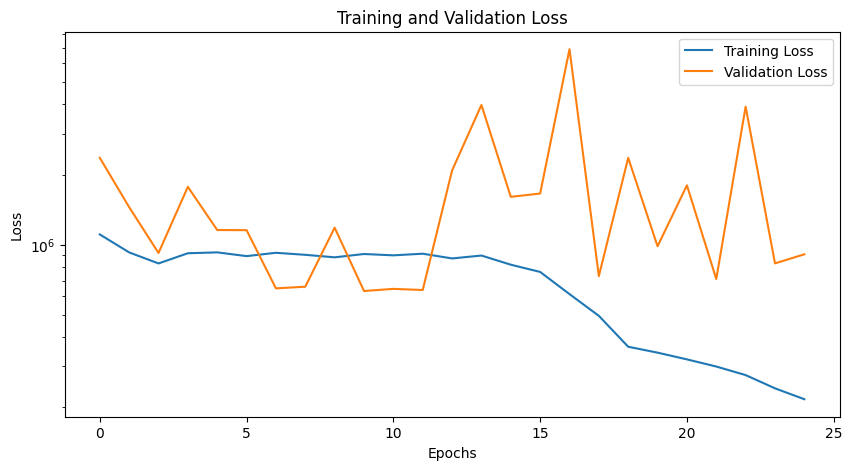

In [ ]:
import matplotlib.pyplot as plt

# visualization of the graph loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.yscale('log')  # Apply logarithmic scale to y-axis
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
